In [17]:
import pandas as pd
import warnings
warnings.simplefilter(action='ignore')
import numpy as np

import os
dfo=pd.DataFrame()

for f in os.listdir('./DataSource/Huazhu/'):
    print(f)
    date=f.split('_')[-1].split('.')[0]
    d=pd.read_csv('./DataSource/Huazhu\%s' % f)
    d['date']=date
    dfo=pd.concat([dfo,d],axis=0)

old=pd.read_hdf(r'Processed_Data/hotel.h5',key='0105')
new=pd.concat([old,dfo])
new=new.drop_duplicates()
new.to_hdf(r'Processed_Data/hotel.h5',key='0105')

In [59]:
d=dfo.copy()
c1=d['brandLevel'].isin(['经济型','舒适型'])
d=d[c1][['date','cityId', 'cityName', 'brandLevel', 'hotelId', 'hotelName', 'roomName','checkInType', 'stock']]
d['checkInType']=d['checkInType'].replace('later','future')
d1=d.groupby(by=['date','cityName', 'brandLevel','hotelName','checkInType','roomName']).mean().reset_index()
d1=d1.groupby(by=['date','cityName', 'brandLevel','checkInType','hotelName']).sum().reset_index()
pv=pd.pivot_table(d1,index=['date','cityName','hotelName'],values='stock',columns='checkInType', aggfunc=np.sum).reset_index()
pv=pv[~pv['now'].isna()]
pv=pv[~pv['future'].isna()]
pv['bookedNights']=pv['future']-pv['now']
pv['hotel_occ']=pv['bookedNights']/pv['future']
c2=pv['now']>5
c3=pv['hotel_occ']<0.9

pv2=pv[c2&c3]
pv2=pv2.groupby(by=['date','cityName']).sum().reset_index()
pv2['city_occ']=pv2['bookedNights']/pv2['future']
pv2=pv2.drop(columns='hotel_occ')

pv2

checkInType,date,cityName,future,now,bookedNights,city_occ
0,2022-06-07,万宁,67.0,20.0,47.0,0.701493
1,2022-06-07,三亚,529.0,241.0,288.0,0.544423
2,2022-06-07,三原县,79.0,32.0,47.0,0.594937
3,2022-06-07,三明,145.0,90.0,55.0,0.379310
4,2022-06-07,三河,154.0,54.0,100.0,0.649351
...,...,...,...,...,...,...
147653,2023-01-03,龙口,212.0,120.0,92.0,0.433962
147654,2023-01-03,龙岩,250.0,168.0,82.0,0.328000
147655,2023-01-03,龙泉,112.0,63.0,49.0,0.437500
147656,2023-01-03,龙港,214.0,89.0,125.0,0.584112


In [99]:
#prepare DF
hotel=pv2
hotel['date']=pd.to_datetime(hotel['date'])
hotel['cityName']=hotel['cityName'].str.replace('市','')

hotel1=hotel.sort_values(by=['cityName','date'])
hotel1['bookedNights_last7d_mean']=hotel1.groupby('cityName')['bookedNights'].transform(lambda x: x.rolling(7, 7).mean())
hotel1['bookedNights_change_WoW']=(hotel1['bookedNights_last7d_mean']/hotel1.groupby('cityName')['bookedNights_last7d_mean'].transform(lambda x: x.shift(periods=7)))-1

c1=hotel1['date'].astype('str')< '2022-07-01'
c2=hotel1['bookedNights']>0
june_mean=hotel1[c1&c2].groupby('cityName').mean().reset_index().sort_values(by='bookedNights')[['cityName','bookedNights']].reset_index(drop=True)
june_mean.columns=['cityName', 'bookedNights_june']

hotel1=hotel1.merge(june_mean,on='cityName')
hotel1['changes_since_june']=hotel1['bookedNights_last7d_mean']/hotel1['bookedNights_june']

#occ changes
hotel1['city_occ_last7d_mean']=hotel1.groupby('cityName')['city_occ'].transform(lambda x: x.rolling(7, 7).mean())
hotel1['city_occ_change_WoW']=(hotel1['city_occ_last7d_mean']/hotel1.groupby('cityName')['city_occ_last7d_mean'].transform(lambda x: x.shift(periods=7)))-1

c1=hotel1['date'].astype('str')< '2022-07-01'
c2=hotel1['bookedNights']>0
june_mean_occ=hotel1[c1&c2].groupby('cityName').mean().reset_index()[['cityName','city_occ']].reset_index(drop=True)
june_mean_occ.columns=['cityName', 'occ_june']

hotel1=hotel1.merge(june_mean_occ,on='cityName')

hotel1['changes_since_june_occ']=hotel1['city_occ_last7d_mean']/hotel1['occ_june']


<AxesSubplot: >

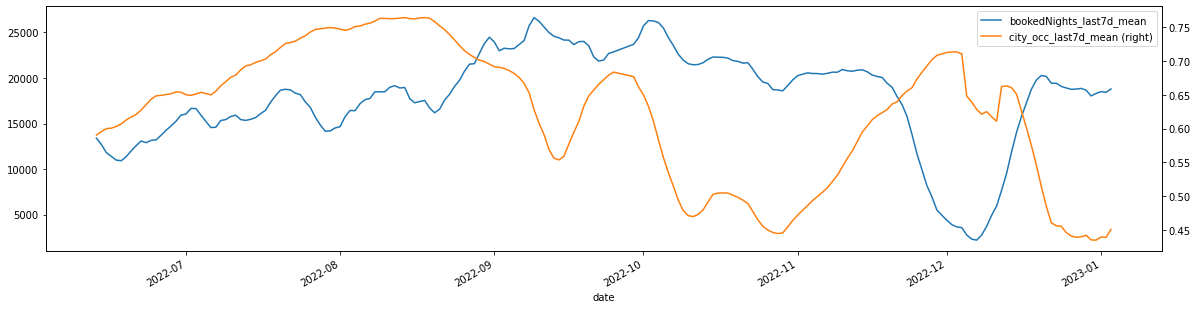

In [98]:
dfp=hotel1[hotel1['cityName']=='北京']
ax = dfp.plot('date','bookedNights_last7d_mean')
dfp.plot('date','city_occ_last7d_mean',secondary_y=True, ax=ax, figsize=(20,5))

In [53]:
# covid rank vs. hotel nights WoW
%load_ext autoreload
%autoreload 2
from colored_list import dafeng_city,jidui_city,riqi
# riqi='2022-12-29'

df_covid=pd.read_hdf('Processed_Data/Baidu_covid_progress.h5',key='raw')

hotel2=hotel1.merge(df_covid,left_on=['cityName'],right_on=['城市'],how='left')

hotel2['date']=hotel2['date'].astype('string')
hotel2=hotel2[hotel2['date']==riqi].sort_values(by='bookedNights_last7d_mean',ascending=False)
hotel2=hotel2[hotel2['bookedNights_change_WoW']<2].head(70).reset_index()

o=hotel2[['cityName',  'progress_2','bookedNights_change_WoW']]


o['size']=np.nan
o['group']='其他'

c1=o['cityName'].isin(dafeng_city)
o.loc[c1,'group']='较早达峰'

o=o.sort_values(by='group',ascending=False)

o.to_clipboard(index=False,header=None)
print(riqi)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2023-01-03


In [54]:
# covid rank vs. hotel nights vs 202206

df_covid=pd.read_hdf('Processed_Data/Baidu_covid_progress.h5',key='raw')

hotel2=hotel1.merge(df_covid,left_on=['cityName'],right_on=['城市'],how='left')

hotel2['date']=hotel2['date'].astype('string')
hotel2=hotel2[hotel2['date']==riqi].sort_values(by='bookedNights_last7d_mean',ascending=False)
hotel2=hotel2[hotel2['changes_since_june']<2].head(70).reset_index()

o=hotel2[['cityName',  'progress_2','changes_since_june']]


o['size']=np.nan
o['group']='其他'

c1=o['cityName'].isin(dafeng_city)
o.loc[c1,'group']='较早达峰'

o=o.sort_values(by='group',ascending=False)

o.to_clipboard(index=False,header=None)
print(riqi)

d=hotel1[hotel1['date']==riqi][['cityName','date','changes_since_june']].reset_index(drop=True).rename(columns={'cityName':'城市','changes_since_june':'hotel'})
d['date']=pd.to_datetime(d['date'])
d.to_hdf('Processed_Data/city_compare.h5',key='hotel')
# d

2023-01-03


In [13]:
# GDP vs. hotel nights WoW

city_popu=pd.read_hdf('Processed_Data/citypopu.h5',key='raw2')

hotel2=hotel1.merge(city_popu,left_on=['cityName'],right_on=['城市'],how='left')

hotel2['date']=hotel2['date'].astype('string')
hotel2=hotel2[hotel2['date']==riqi].sort_values(by='bookedNights_last7d_mean',ascending=False)
hotel2=hotel2[hotel2['bookedNights_change_WoW']<2].head(70).reset_index()

o=hotel2[['cityName',  'GDP','bookedNights_change_WoW']]


o['size']=np.nan
o['group']='其他'

c1=o['cityName'].isin(dafeng_city)
o.loc[c1,'group']='较早达峰'

o=o.sort_values(by='group',ascending=False)

o.to_clipboard(index=False,header=None)
print(riqi)

2023-01-03


In [89]:
# GDP vs. hotel nights vs 202206

city_popu=pd.read_hdf('Processed_Data/citypopu.h5',key='raw2')

hotel2=hotel1.merge(city_popu,left_on=['cityName'],right_on=['城市'],how='left')

hotel2['date']=hotel2['date'].astype('string')
hotel2=hotel2[hotel2['date']==riqi].sort_values(by='bookedNights_last7d_mean',ascending=False)
hotel2=hotel2[hotel2['changes_since_june_occ']<2].head(70).reset_index()

o=hotel2[['cityName',  'GDP','changes_since_june']]


o['size']=np.nan
o['group']='其他'

c1=o['cityName'].isin(dafeng_city)
o.loc[c1,'group']='较早达峰'

o=o.sort_values(by='group',ascending=False)

o.to_clipboard(index=False,header=None)
print(riqi)

2023-01-03


In [13]:
d1=pd.read_clipboard()
d2=pd.pivot_table(new[new['date']>'2022-12-28'],index='cityName',columns='date',values='bookedNights',aggfunc='sum').reset_index()
d1.merge(d2,left_on='城市',right_on='cityName',how='left').to_clipboard(index=False)